In [1]:
import sys
sys.path.append('../src')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, Input, layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow_addons.metrics import FBetaScore
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
import tensorflow as tf
# from tensorflow.keras.metrics import Recall, Precision

from utils.data import get_best_slice, select_tomo_ids, get_csv_from_bq
from utils.render_motor_position import get_motor_coordinates, get_slice_file_path
from ml_logic.interface import train_classification

/Users/wm/.pyenv/versions/3.10.6/envs/byu/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/wm/.pyenv/versions/3.10.6/envs/byu/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter 


Loading TensorFlow...


In [2]:
# path_tomos= '/Users/wm/code/mc-will/bacterial_motor/BYU_Locating-Bacterial_Flagellar_Motors_2025/data/pictures_raw/train'
path_light= '/Volumes/DiskMorgane/light_data'
# path_heavy= '/Volumes/DiskMorgane/bach_32/bach_1'
path_train_csv= '../data/csv_raw/train_labels.csv'


df = pd.read_csv(path_train_csv).copy()

In [3]:
# position du motor en 32 photos
df['motor_place'] = np.where( df['Motor_axis_0'] < 0,-1,(df['Motor_axis_0'] / df['Array_shape_axis_0'] * 32).astype(int))
# group by tomo_id
df = df.groupby('tomo_id').first().reset_index()


In [4]:

tomo_ids = ['tomo_00e047', 'tomo_0fe63f', 'tomo_1e9980']
df = df[df['tomo_id'].isin(tomo_ids)]


In [5]:

# put 1 in the line wher teh motor is , 0 if no

new_files = []

for _, file in df.iterrows():
    # Crear 32 copias de la fila
    for i in range(32):
        new_file = file.copy()
        new_file['motor_place'] = 1 if i == int(file['motor_place']) else 0
        new_files.append(new_file)

df = pd.DataFrame(new_files)
df.reset_index(drop=True, inplace=True)
df


,tomo_id,Unnamed: 0,row_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors,motor_place
0,tomo_00e047,338,1,169.0,546.0,603.0,300,959,928,15.6,1,0
1,tomo_00e047,338,1,169.0,546.0,603.0,300,959,928,15.6,1,0
2,tomo_00e047,338,1,169.0,546.0,603.0,300,959,928,15.6,1,0
3,tomo_00e047,338,1,169.0,546.0,603.0,300,959,928,15.6,1,0
4,tomo_00e047,338,1,169.0,546.0,603.0,300,959,928,15.6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
91,tomo_1e9980,172,85,-1.0,-1.0,-1.0,300,960,928,16.8,0,0
92,tomo_1e9980,172,85,-1.0,-1.0,-1.0,300,960,928,16.8,0,0
93,tomo_1e9980,172,85,-1.0,-1.0,-1.0,300,960,928,16.8,0,0
94,tomo_1e9980,172,85,-1.0,-1.0,-1.0,300,960,928,16.8,0,0


In [6]:
import os
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm

def load_tomos_from_df(path_light_data, df, size=512, num_tomos=648, id_column='tomo_id'):
    """
    Loads images from 'tomo_*' folders specified in a DataFrame.

    Parameters:
    - path_light_data: Base path where 'tomo_*' folders are located
    - df: DataFrame containing tomo IDs
    - size: Desired image size (default is 512x512)
    - num_tomos: Number of tomos to load (from the DataFrame rows)
    - id_column: Name of the column in df containing folder names (e.g., 'tomo_00e047')

    Returns:
    - NumPy array with shape (num_tomos * 32, size, size, 1)
    """
    all_images = []

    # Get tomo IDs from the DataFrame
    tomo_ids = df[id_column].head(num_tomos).tolist()

    for tomo_id in tqdm(tomo_ids, desc="Processing tomos from DataFrame"):
        tomo_path = os.path.join(path_light_data, tomo_id)

        if not os.path.exists(tomo_path):
            print(f"⚠️ Folder not found: {tomo_path}")
            continue

        # Read up to 32 valid images
        image_files = sorted([
            f for f in os.listdir(tomo_path)
            if f.lower().endswith(('.png', '.jpg')) and not f.startswith("._")
        ])[:32]

        for img_file in image_files:
            img_path = os.path.join(tomo_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"⚠️ Could not read {img_path}")
                continue
            img_resized = cv2.resize(img, (size, size))
            img_expanded = np.expand_dims(img_resized, axis=-1)
            all_images.append(img_expanded)

    array_final = np.stack(all_images, axis=0)  # (num_tomos*32, size, size, 1)
    print("✅ Final array shape:", array_final.shape)
    return array_final

# Example usage:
X = load_tomos_from_df(path_light,
                       df=df,
                       num_tomos=648,
                       id_column='tomo_id'
                       )


Processing tomos from DataFrame: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


✅ Final array shape: (96, 512, 512, 1)


In [7]:
y= df['motor_place']

In [8]:
random_state=42

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.05,
                                                    random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2,
                                                  random_state=random_state)

In [9]:

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, Input, layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow_addons.metrics import FBetaScore
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
# from tensorflow.keras.metrics import Recall, Precision


def init_model_densenet(X):
    original_input_shape = X.shape[1:]

    #  force input to 3 channel if it's grey (1 canal)
    if original_input_shape[-1] == 1:
        base_input_shape = original_input_shape[:-1] + (3,)
    else:
        base_input_shape = original_input_shape

    # load DenseNet121 without last classify layer
    base_model = DenseNet121(include_top=False,
                             weights='imagenet',
                             input_shape=base_input_shape
                             )
    base_model.trainable = False

    # Input layer
    inputs = Input(shape=original_input_shape)

    # convert in RGB if need it,
    if original_input_shape[-1] == 1:
        x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(inputs)
    else:
        x = inputs

    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=[
            'accuracy',
            # FBetaScore(num_classes=1,
            #            beta=2.0),
            Recall(),
            Precision(),
        ]
    )

    return model


def model_train (model, X_train_processed, y_train, batch_size=16 ,epochs=5):
    verbose=1
    validation_split=0.1
    es = EarlyStopping(patience=3,
                       restore_best_weights=True)

    history = model.fit(X_train_processed,
                        y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        # validation_split=validation_split,
                        validation_data=(X_val, y_val),
                        callbacks=[es],
                        verbose=verbose)
    return history


In [10]:
model = init_model_densenet(X_train)

In [11]:

history = model_train(model, X_train,y_train)
history

Epoch 1/5


2025-06-09 17:25:36.966116: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 15s 3s/step - loss: 0.3458 - accuracy: 0.9167 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.5755e-04 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/5
5/5 [==============================] - 11s 2s/step - loss: 0.3530 - accuracy: 0.9583 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 7.7460e-05 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/5
5/5 [==============================] - 11s 2s/step - loss: 0.4384 - accuracy: 0.9444 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 5.7582e-05 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/5
5/5 [==============================] - 12s 2s/step - loss: 0.4190 - accuracy: 0.9583 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 5.2129e-05 - val_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/5
5/5 [==============================] - 12s 2

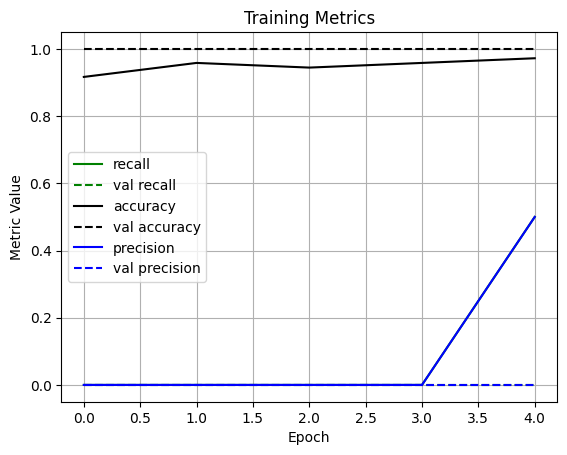

In [12]:
def plot_training_metrics(history):
    """
   plot the metrics, even if there is not one of them into 'history'
    """
    history_dict = history.history
    plotted = False

    def safe_plot(metric_name, color, linestyle='-'):
        nonlocal plotted
        if metric_name in history_dict:
            label = metric_name.replace('_', ' ')
            plt.plot(history_dict[metric_name], c=color, linestyle=linestyle, label=label)
            plotted = True

    # fbeta
    safe_plot('fbeta_score', 'r')
    safe_plot('val_fbeta_score', 'r', '--')

    # recall
    safe_plot('recall', 'g')
    safe_plot('val_recall', 'g', '--')
    safe_plot('recall_1', 'g')  # alternativa por si usa nombre automático
    safe_plot('val_recall_1', 'g', '--')

    # accuracy
    safe_plot('accuracy', 'black')
    safe_plot('val_accuracy', 'black', '--')

    # precision
    safe_plot('precision', 'blue')
    safe_plot('val_precision', 'blue', '--')

    if plotted:
        plt.title("Training Metrics")
        plt.xlabel("Epoch")
        plt.ylabel("Metric Value")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("⚠️ No se encontró ninguna métrica conocida para graficar.")

plot_training_metrics(history)

In [13]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 1s 642ms/step - loss: 6.3106e-05 - accuracy: 1.0000 - recall: 0.0000e+00 - precision: 0.0000e+00


[6.310566095635295e-05, 1.0, 0.0, 0.0]

In [14]:
y_pred= model.predict(X_test )
y_pred

1/1 [==============================] - 2s 2s/step


array([[7.8173180e-05],
       [1.0626580e-04],
       [7.6965705e-05],
       [2.2398297e-06],
       [5.1870782e-05]], dtype=float32)

In [16]:
from sklearn.metrics import fbeta_score

# Obtener predicciones del modelo para el set de validación
y_val_pred_prob = model.predict(X_val)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Calcular F-beta ponderado
fbeta = fbeta_score(y_val, y_val_pred, beta=2, average='weighted')
# fbeta = fbeta_score(y_val, y_val_pred, beta=2)
print(f"F-beta score ponderado (beta=2) en validación: {fbeta:.4f}")

1/1 [==============================] - 3s 3s/step
F-beta score ponderado (beta=2) en validación: 1.0000
